# Mini Project : Histopathologic Cancer Detection

## Introduction

Histopathologic cancer detection is an essential aspect of cancer diagnosis, traditionally reliant on the expertise of pathologists who visually analyze microscopic images. Recent advancements in deep learning techniques have introduced a promising avenue to enhance the accuracy and efficiency of this diagnostic process. In this mini project, we embark on a beginner's journey into the realm of convolutional neural networks (CNNs) to detect cancerous regions in histopathologic images.

## Loading the necessary libraries

In this section, we load the libraries required for our project.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
import cv2
from PIL import Image
from tifffile import imread
import pathlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')
random_state=0

## Data Preparation

### 1. Check the number of rows in each folders

We inspect the number of rows (images) in both the training and test datasets:

In [2]:
# number of rows in the train datasets

# Directory containing the TIFF images
directory_train = 'data/train/'

# List all files in the directory
train_dir = os.listdir(directory_train)

# Filter the files to include only those with the ".tif" extension
train_files = [file for file in train_dir if file.endswith('.tif')]

# Count the number of TIFF images
train_num = len(train_files)

print(f"Number of TIFF images in the 'train' folder: {train_num}")

Number of TIFF images in the 'train' folder: 220025


In [3]:
# number of rows in the test datasets
directory_test = 'data/test/'
test_dir = os.listdir(directory_test)
test_files = [file for file in test_dir if file.endswith('.tif')]
test_num = len(test_files)
print(f"Number of TIFF images in the 'test' folder: {test_num}")

Number of TIFF images in the 'test' folder: 57458


### 2. Check all the images are in the same size

To ensure consistency, we verify that all images in both the 'train' and 'test' folders have the same dimensions.

In [4]:
# make sure all the images are in the same size

def images_consistent(directory_path):
    consistent_num = 0
    inconsistent_num = 0
    
    image_files = [file for file in os.listdir(directory_path) if file.lower().endswith('.tif')]
    
    first_image_width = None
    first_image_height = None
    
    for image_file in image_files:
        # Construct the full path to the image
        image_path = os.path.join(directory_path, image_file)

        # Use OpenCV to read the image
        image_cv2 = cv2.imread(image_path)

        # Use Pillow to get the image dimensions
        image_pillow = Image.open(image_path)
        width, height = image_pillow.size

        # If this is the first image, store its dimensions
        if first_image_width is None:
            first_image_width = width
            first_image_height = height

        # Compare the dimensions with the first image
        if width != first_image_width or height != first_image_height:
            inconsistent_num += 1
        else:
            consistent_num += 1
            # Check if all images have the same dimensions
    if inconsistent_num == 0:
        return 'Yes'
    else:
        return 'No'

In [5]:
# check the images in the train folder are in the same size
images_consistent('data/train/')

'Yes'

In [6]:
# check the images in the test folder are in the same size
images_consistent('data/test/')

'Yes'

### 3. Check the image shape

We check the dimensions of one example image, which provides us with the image's width and height.

In [7]:
train_data_dir = './data/train'

# load the trainning labels
train_labels = pd.read_csv('./data/train/_labels.csv')

In [8]:
# get the image dimensions
example_image = f"{train_labels['id'].iloc[0]}.tif"
example_path = os.path.join(directory_train, example_image)
img_example = Image.open(example_path)
width, height = img_example.size

print(f"Image dimensions: {width}x{height}")

Image dimensions: 96x96


### 4. Data Visualization

We display the first 10 images with label 0 and the first 10 images with label 1 for initial data visualization.

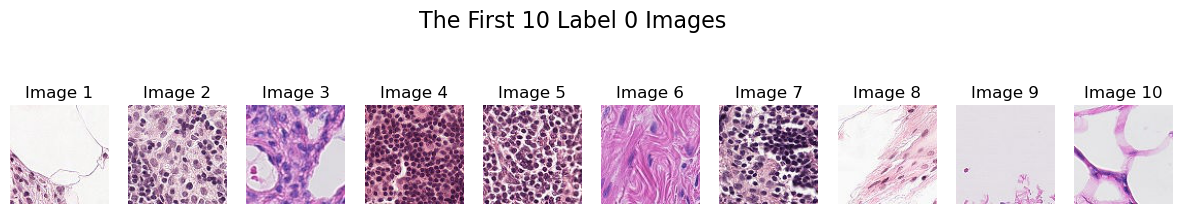

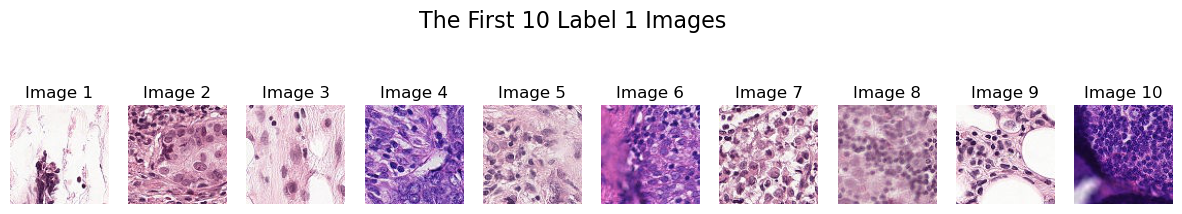

In [9]:
# the first 10 images with label == 0 and the first 10 images with label == 1

first_0_img = train_labels[train_labels['label'] == 0].head(10)
first_1_img = train_labels[train_labels['label'] == 1].head(10)

def read_and_display_images(image_ids,plot_label):
    num_images = len(image_ids)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    for i, (_, row) in enumerate(image_ids.iterrows()):
        image_id = row['id']
        image_path = os.path.join(directory_train, f"{image_id}.tif")
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i + 1}")
    
    plt.suptitle(plot_label, fontsize=16)
    plt.show()

read_and_display_images(first_0_img, "The First 10 Label 0 Images")
read_and_display_images(first_1_img, "The First 10 Label 1 Images")

In this section, we aim to gain insights into the images' pixel values. We use the function display_pixel_stats_and_histogram to display pixel statistics and histograms for the first 10 images of each class.

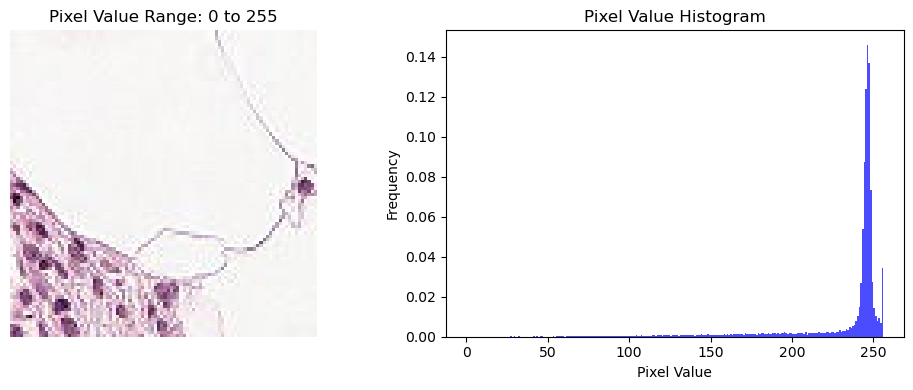

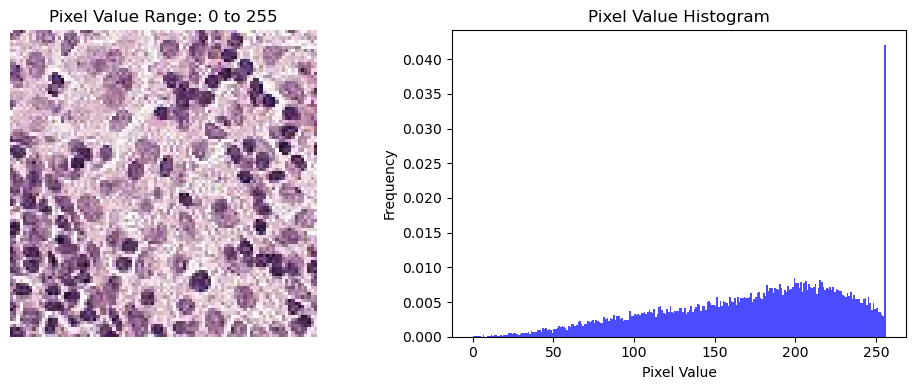

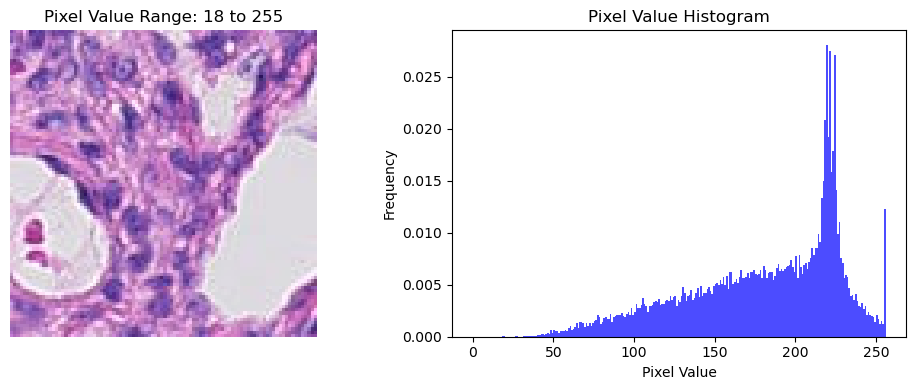

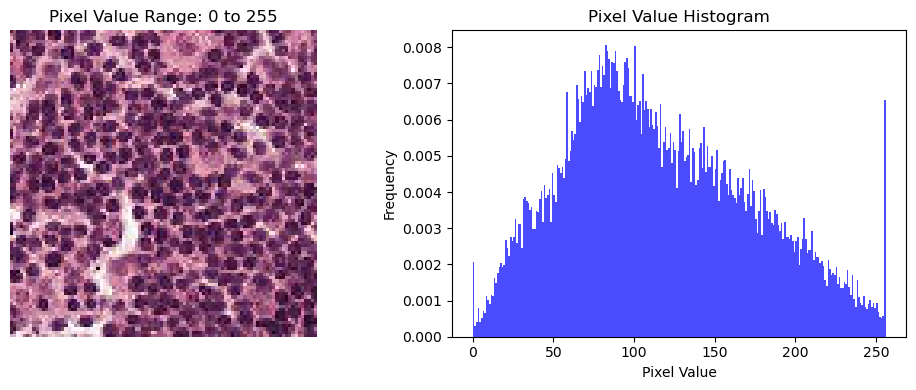

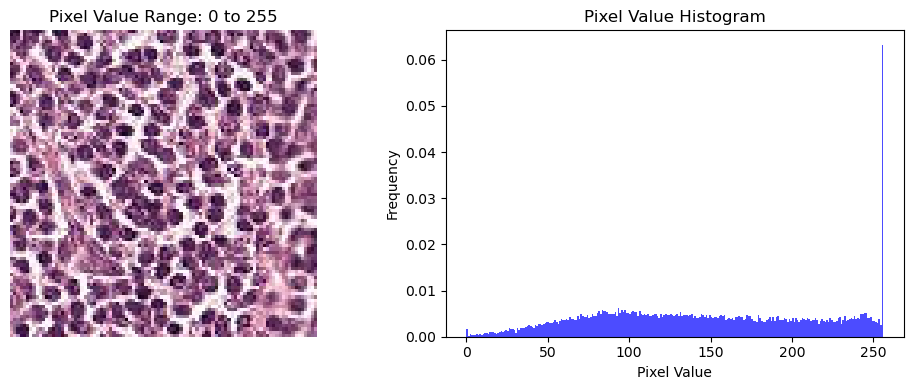

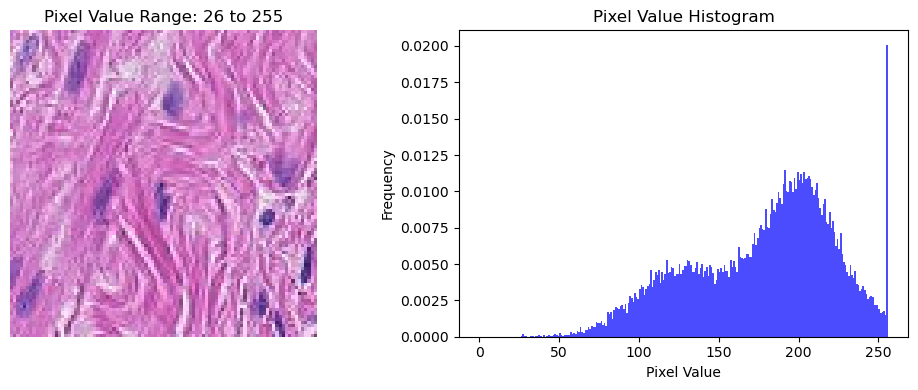

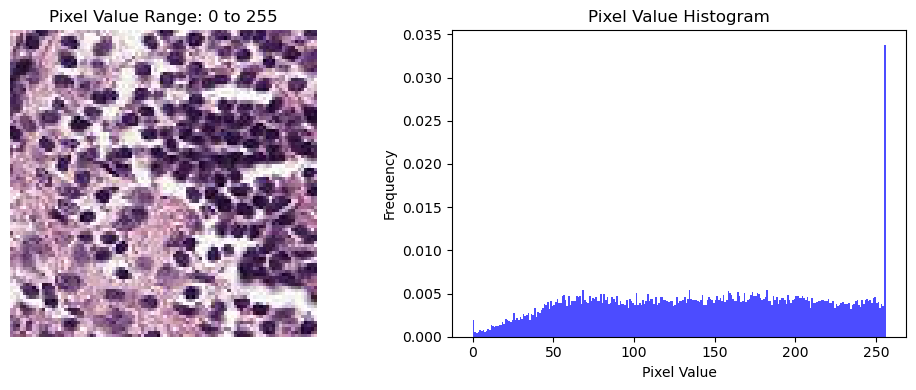

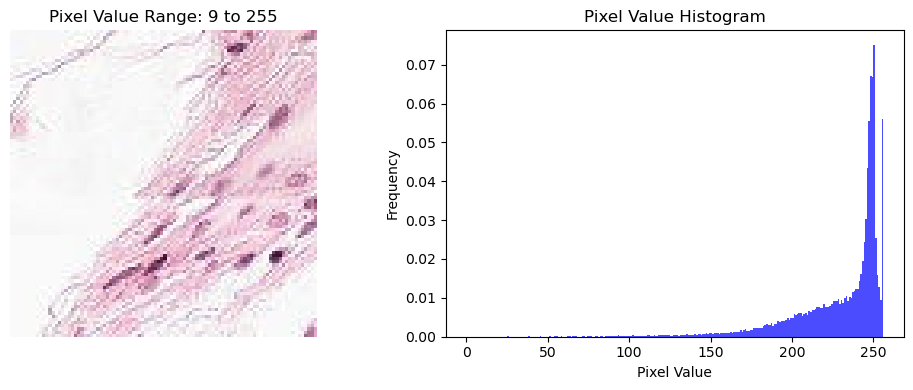

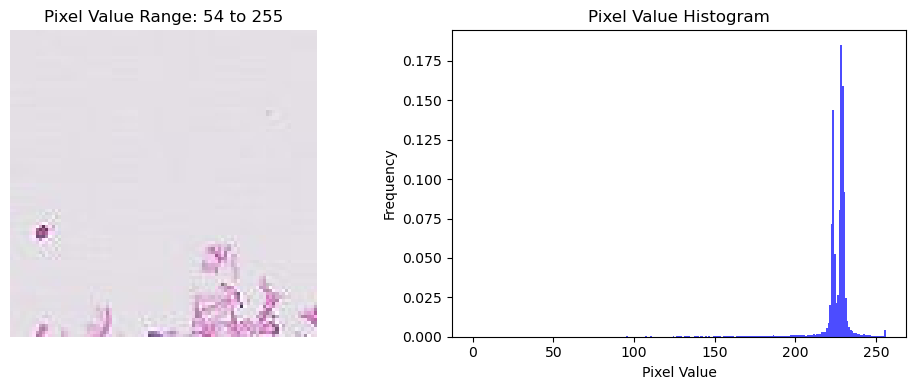

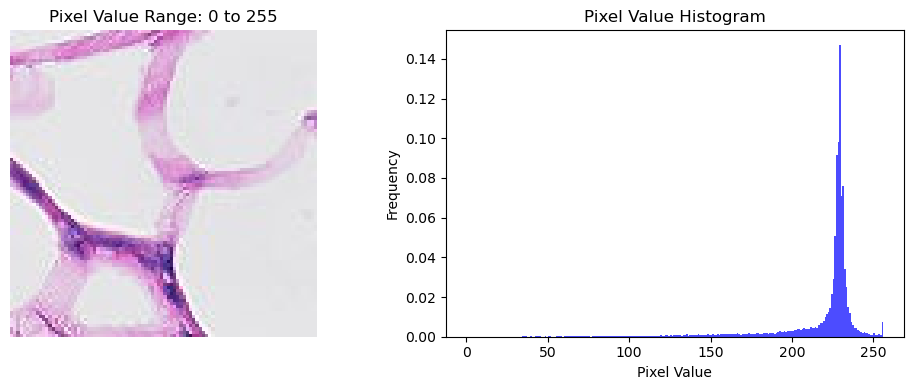

In [10]:
# Define the function to display the images and their pixel histograms.

def display_pixel_stats_and_histogram(image):
    img_array = np.array(image)
    min_pixel = np.min(img_array)
    max_pixel = np.max(img_array)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Pixel Value Range: {min_pixel} to {max_pixel}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.hist(img_array.ravel(), bins=256, range=(0, 256), density=True, color='b', alpha=0.7)
    plt.title('Pixel Value Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
# Display pixel value range and histograms for the first 10 Label 0 images
for i, (_, row) in enumerate(first_0_img.iterrows()):
    image_id = row['id']
    image_path = os.path.join(directory_train, f"{image_id}.tif")
    image = Image.open(image_path)
    display_pixel_stats_and_histogram(image)

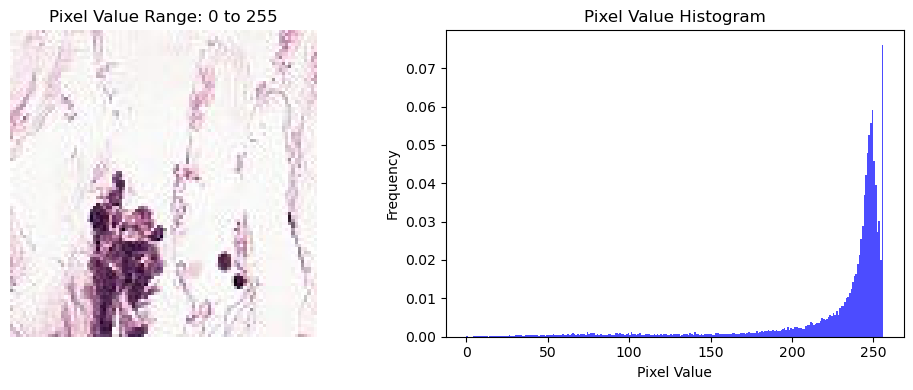

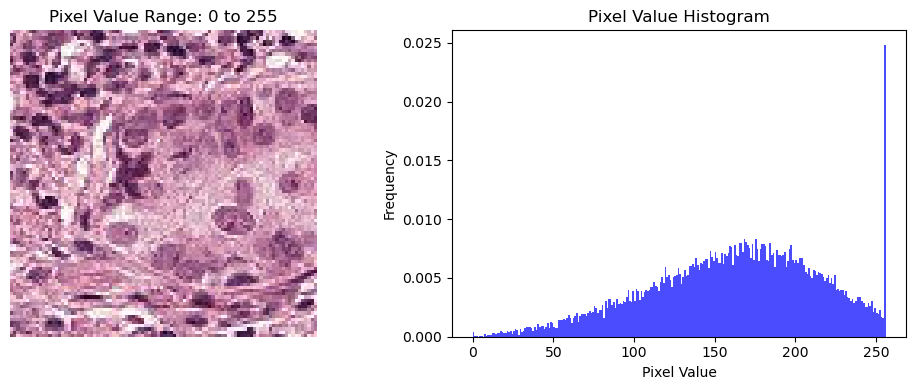

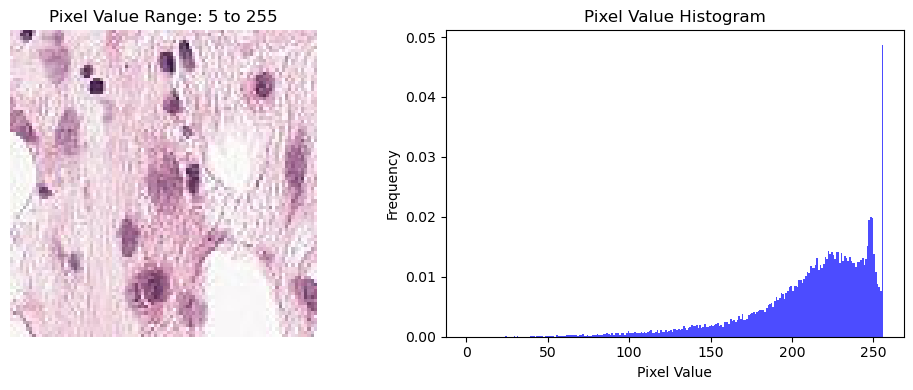

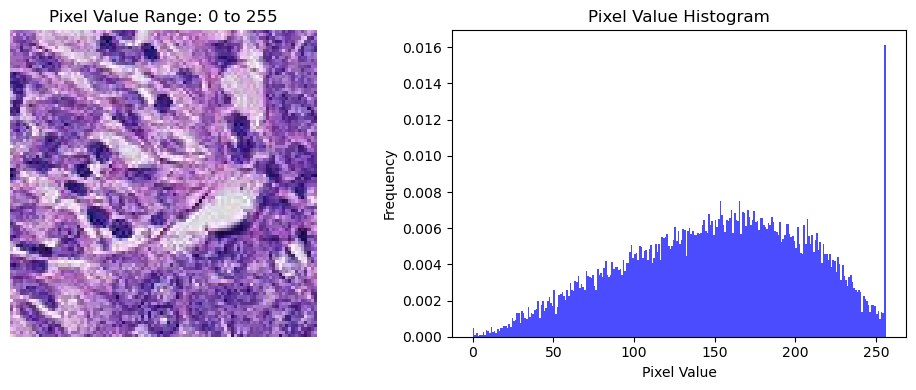

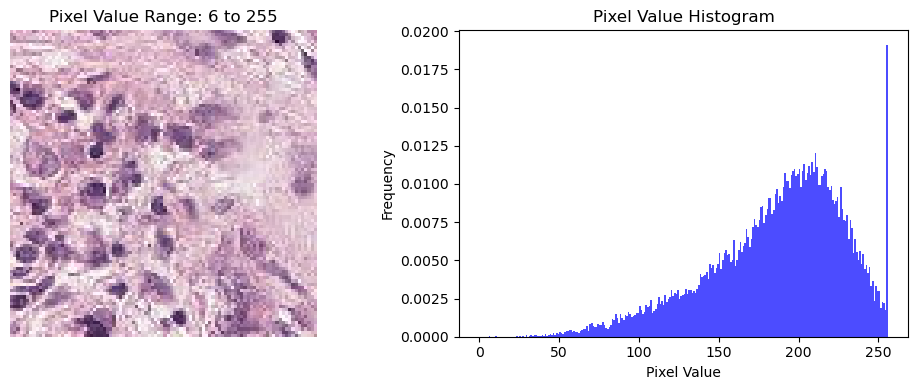

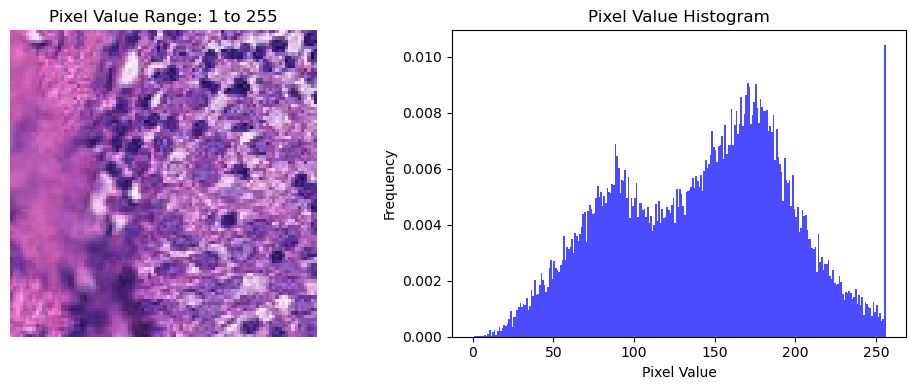

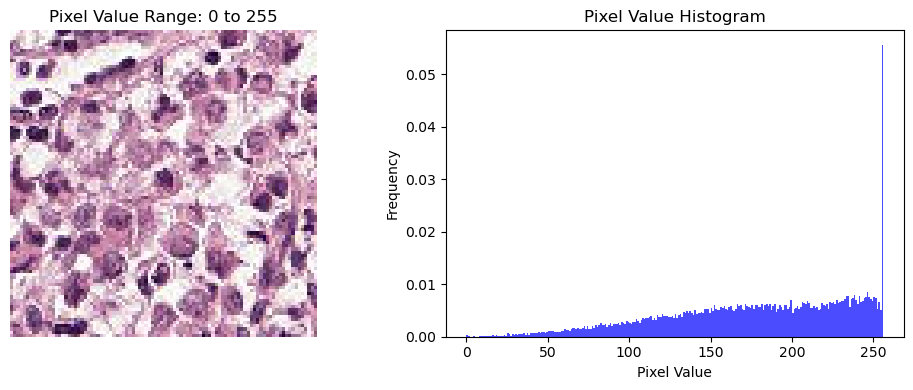

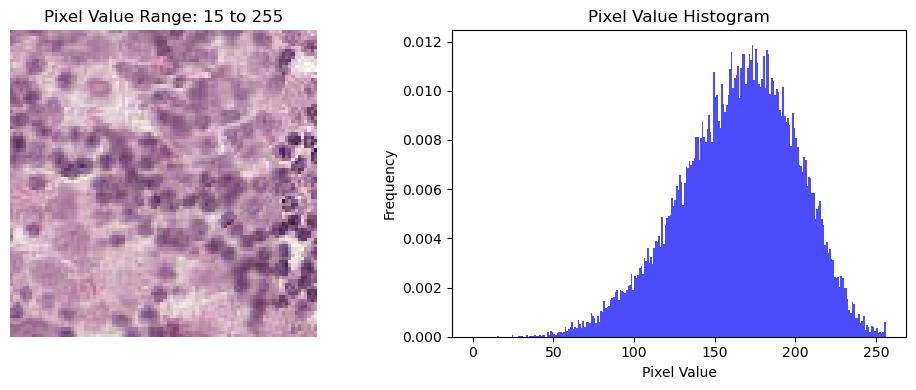

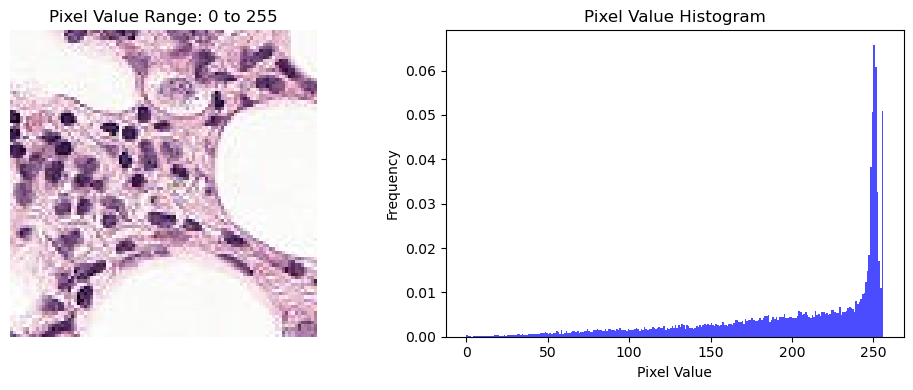

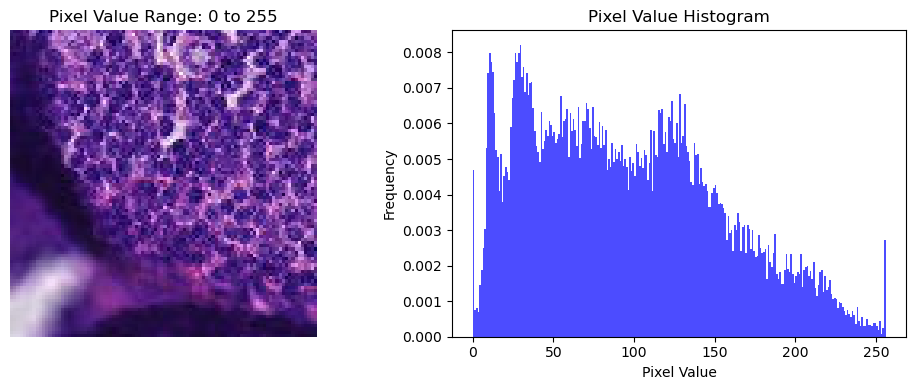

In [11]:
# Display pixel value range and histograms for the first 10 Label 1 images
for i, (_, row) in enumerate(first_1_img.iterrows()):
    image_id = row['id']
    image_path = os.path.join(directory_train, f"{image_id}.tif")
    image = Image.open(image_path)
    display_pixel_stats_and_histogram(image)

### 5. Data Balance

Data balancing is crucial for model training, especially when dealing with imbalanced datasets. We employ the RandomOverSampler from the imbalanced-learn library to balance the training data by oversampling the minority class.

In [12]:
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

According to the counts, the trainning data is imbalanced. The oversampling method will be used in the later sections. The plot of sample number of trainning data in each class is shown below.

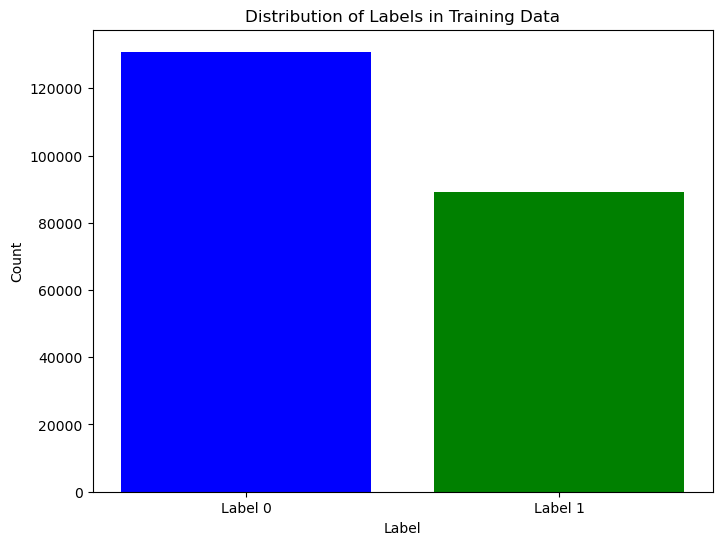

In [13]:
# plot the unbalanced data

label_counts = train_labels['label'].value_counts()

plt.figure(figsize=(8,6))
plt.bar(label_counts.index, label_counts.values, color=['blue','green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1],["Label 0","Label 1"])
plt.title("Distribution of Labels in Training Data")
plt.show()

### 6. Data Pipeline

Here, we create a data pipeline for training and validation since there are extremely large training dataset which might cause our system kernel crash easily. The ImageDataGenerator is used to preprocess the data and generate batches for model training. We define the batch size, target size, and class mode.

In [14]:
# split the data into train and validation

train, validation, train_label, validation_label = train_test_split(train_labels['id'],train_labels['label'],test_size=0.2,random_state = random_state)


In [15]:
# check out train data
train_label.value_counts()

label
0    104765
1     71255
Name: count, dtype: int64

In [16]:
# check out validation data
validation_label.value_counts()

label
0    26143
1    17862
Name: count, dtype: int64

In [17]:
# oversampling on train data

t_x = np.array(train)
t_y = np.array(train_label)

# Reshape t_x to be a 2D array
t_x = t_x.reshape(-1, 1)

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=random_state)
new_id, new_label = oversampler.fit_resample(t_x, t_y)

In [18]:
# create the train dataset: df

new_id = new_id.reshape(-1)
new_label = new_label.reshape(-1)

df = pd.DataFrame({'id': new_id, 'label': new_label})

# Check the shape of the resulting DataFrame
print(df.shape)


(209530, 2)


In [19]:
df['id'] = df['id'] + '.tif'

In [20]:
df['label'].value_counts()

label
1    104765
0    104765
Name: count, dtype: int64

In [21]:
df[:5]

,id,label
0,a42ed368dfea7e31fcde574fc9ab5ec921642cd4.tif,1
1,54946370aec5fe50c6c8595e880f58051445b007.tif,1
2,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf.tif,1
3,09afaac18518e435c68fc1b635690c79b52d1a0e.tif,0
4,8ab7670b07494ca3b51b570fc243467a7a45895c.tif,1


In [22]:
# create the validation dataset: df_validation

validation = np.array(validation)
validation_label = np.array(validation_label)

validation = validation.reshape(-1)
validation_label = validation_label.reshape(-1)

df_validation = pd.DataFrame({'id': validation, 'label': validation_label})


df_validation['id'] = df_validation['id'] + '.tif'

In [23]:
# demonstrate the first 5 rows of validation data
df_validation[:5]

,id,label
0,39ca8cf79f1936784afc21435144881db9f36958.tif,1
1,4219c24487a618efc64d9c76648fa05a0c730032.tif,1
2,cbd614cce8cb5523b912231eadc01cdae1aec62b.tif,0
3,0470cc5eeb1fec51a56ffe7d06da91b69407859e.tif,1
4,c11611378750179d47b66c9771b1caf909e76418.tif,1


In [24]:
df['label'] = df['label'].astype(str)
df_validation['label']=df_validation['label'].astype(str)

In next section, due to the simpleness of our CNN model, we will not use the data augumentation in case of introducing some noise into our trainning process. 

In [33]:
# create a data pipeline

batch_size = 1000

datagen = ImageDataGenerator(
    rescale=1./255.0,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.2
)            

train_data_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_data_dir,
    x_col="id",
    y_col="label",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

validation_datagen = ImageDataGenerator(
    rescale=1./255.0
)

validation_data_generator = validation_datagen.flow_from_dataframe(
    dataframe=df_validation,
    directory=train_data_dir,
    x_col="id",
    y_col="label",
    target_size=(32,32),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True

)

Found 209530 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## CNN Model

In [42]:
from tensorflow.keras.layers import BatchNormalization

dropout_dense_layer = 0.5

model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', strides=1, padding='valid',input_shape=(32, 32, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', strides=1,padding='valid'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), activation='relu', strides=1,padding='valid'))
model.add(MaxPooling2D())


model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_dense_layer))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 15, 15, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        73792     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 4, 4, 16)          9232      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 2, 2, 16)        

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [45]:
epochs = 20
history = model.fit_generator(train_data_generator,
          validation_data= validation_data_generator,
          epochs=epochs,
          callbacks=callbacks)

Epoch 1/20
210/210 [==============================] - 104s 492ms/step - loss: 0.5321 - accuracy: 0.7552 - val_loss: 0.6511 - val_accuracy: 0.5569 - lr: 0.0010
Epoch 2/20
210/210 [==============================] - 105s 500ms/step - loss: 0.4797 - accuracy: 0.7886 - val_loss: 0.5599 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 3/20
210/210 [==============================] - 106s 506ms/step - loss: 0.4325 - accuracy: 0.8114 - val_loss: 0.3986 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 4/20
210/210 [==============================] - 108s 515ms/step - loss: 0.4145 - accuracy: 0.8197 - val_loss: 0.3878 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 5/20
210/210 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8237
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
210/210 [==============================] - 102s 485ms/step - loss: 0.4079 - accuracy: 0.8237 - val_loss: 0.4622 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 6/20
210/210 [========================

## Model Performance

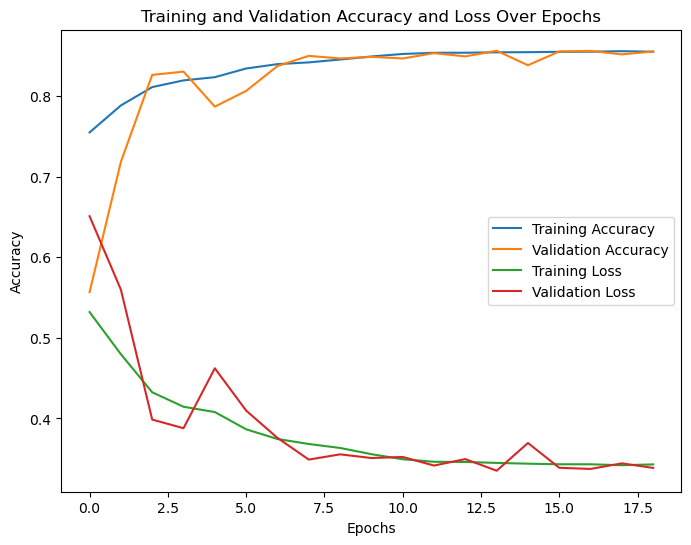

In [64]:
# Plot the accuracy of train data and validation data in each epoch
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy and Loss Over Epochs')
plt.show()

## Test Data and Prediction

In [47]:
import pathlib

test_dir = './data/test'
test_data_dir = pathlib.Path(test_dir)
test_paths = list(test_data_dir.glob('*.tif'))

In [48]:
test_df = pd.DataFrame({'id': test_paths})
test_df['id'] = test_df['id'].apply(str) 

In [49]:
# test data preparation
test_datagen = ImageDataGenerator(rescale=1./255.0)

In [52]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="id",
    y_col=None,
    target_size=(32,32),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [53]:
# load the best model
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

In [55]:
# make the prediction

predictions = best_model.predict(test_generator)

58/58 [==============================] - 21s 360ms/step


In [56]:
binary_predictions = (predictions > 0.5).astype(int)

In [57]:
test_df['label'] = binary_predictions

In [59]:
test_df['id'] = test_df['id'].str.split('/').str[-1].str.replace('.tif', '')

In [61]:
# Save the submission file
test_df.to_csv('submission.csv', index=False)

In [62]:
test_df.shape

(57458, 2)

## Conclusion

In this project, we have developed a fundamental CNN model that achieves an approximate accuracy of 85%. Due to the substantial volume of data, the system kernel can be susceptible to crashes. Therefore, we have chosen this basic CNN model, which not only delivers reasonably high accuracy but also allows for efficient training. Nonetheless, there is room for us to explore more intricate and deeper models as we progress in our learning journey.